<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/MLP_AE/MLP_AE_Cu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 10.09 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Fri Jul 23 14:00:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Cu'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'MLP_AE'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 8.9 MB/s 
     |████████████████████████████████| 170 kB 58.1 MB/s 
     |████████████████████████████████| 133 kB 57.4 MB/s 
     |████████████████████████████████| 97 kB 7.2 MB/s 
     |████████████████████████████████| 138 kB 51.9 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(Dense(256, activation=config.activation, input_shape=(window_len, 1)))
    # layer 2
    model.add(Dense(128, activation=config.activation))
    # layer 3
    model.add(Dense(64, activation=config.activation))
    # layer 4
    model.add(Dense(32, activation=config.activation))
    # layer 5
    model.add(Flatten())
    # layer 6
    model.add(RepeatVector(window_len))
    # layer 7
    model.add(Dense(32, activation=config.activation))
    # layer 8
    model.add(Dense(64, activation=config.activation))
    # layer 9
    model.add(Dense(128, activation=config.activation))
    # layer 10
    model.add(Flatten())
    # layer 11
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: zbbku11l
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_MLP_AE/sweeps/zbbku11l


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: 8ankoi5t with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/100
16/16 [==============================] - 16s 65ms/step - loss: 0.5105 - mean_squared_error: 0.5105 - mean_absolute_error: 0.5421 - val_loss: 0.0859 - val_mean_squared_error: 0.0859 - val_mean_absolute_error: 0.2367
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0548 - mean_squared_error: 0.0548 - mean_absolute_error: 0.1891 - val_loss: 0.0488 - val_mean_squared_error: 0.0488 - val_mean_absolute_error: 0.1691
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0387 - mean_squared_error: 0.0387 - mean_absolute_error: 0.1610 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0852
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0932 - val_loss: 0.0200 - val_mean_squared_error: 0.0200 - val_mean_absolute_error: 0.1101
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0206 - mean_squared

epoch,31
loss,0.00102
mean_squared_error,0.00102
mean_absolute_error,0.02493
val_loss,0.005
val_mean_squared_error,0.005
val_mean_absolute_error,0.05469
_runtime,28
_timestamp,1627048895
_step,31
best_val_loss,0.00426


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▃▂▁▂▁▁▁▁▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▄▁▁▁▁
mean_squared_error,█▃▂▁▂▁▁▁▁▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▄▁▁▁▁
mean_absolute_error,█▄▃▂▃▂▂▂▁▃▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▇▆▂▁▁▁
val_loss,▆▄▂▂▂▂▂▁▁▆▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁
val_mean_squared_error,▆▄▂▂▂▂▂▁▁▆▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁
val_mean_absolute_error,▆▅▂▃▂▂▂▁▂▇▃▃▁▂▂▁▁▁▁▁▁▁▁▁▁▂█▂▁▁▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 5myqcq0v with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 2s 88ms/step - loss: 0.3202 - mean_squared_error: 0.3202 - mean_absolute_error: 0.4932 - val_loss: 0.2442 - val_mean_squared_error: 0.2442 - val_mean_absolute_error: 0.4171
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.2688 - mean_squared_error: 0.2688 - mean_absolute_error: 0.4440 - val_loss: 0.2050 - val_mean_squared_error: 0.2050 - val_mean_absolute_error: 0.3717
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.2261 - mean_squared_error: 0.2261 - mean_absolute_error: 0.3947 - val_loss: 0.1667 - val_mean_squared_error: 0.1667 - val_mean_absolute_error: 0.3212
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.1900 - mean_squared_error: 0.1900 - mean_absolute_error: 0.3574 - val_loss: 0.1315 - val_mean_squared_error: 0.1315 - val_mean_absolute_error: 0.2747
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.1538 - mean_squared_error: 0.153

epoch,99
loss,0.00443
mean_squared_error,0.00443
mean_absolute_error,0.05149
val_loss,0.01555
val_mean_squared_error,0.01555
val_mean_absolute_error,0.09114
_runtime,17
_timestamp,1627048921
_step,99
best_val_loss,0.0155


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▅▄▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▄▄▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 3w232ynk with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 3s 46ms/step - loss: 8.5360 - mean_squared_error: 8.5360 - mean_absolute_error: 1.4912 - val_loss: 0.0237 - val_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.1280
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0415 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1550 - val_loss: 0.0814 - val_mean_squared_error: 0.0814 - val_mean_absolute_error: 0.2456
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0384 - mean_squared_error: 0.0384 - mean_absolute_error: 0.1442 - val_loss: 0.0536 - val_mean_squared_error: 0.0536 - val_mean_absolute_error: 0.1988
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0472 - mean_squared_error: 0.0472 - mean_absolute_error: 0.1711 - val_loss: 0.0869 - val_mean_squared_error: 0.0869 - val_mean_absolute_error: 0.2347
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0402 - mean_squared_erro

epoch,19
loss,0.01246
mean_squared_error,0.01246
mean_absolute_error,0.08066
val_loss,0.02829
val_mean_squared_error,0.02829
val_mean_absolute_error,0.14206
_runtime,9
_timestamp,1627048937
_step,19
best_val_loss,0.00859


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,▂▇▅▇█▃▄▁▇▁▂▂▃▂▂▂▁▁▁▃
val_mean_squared_error,▂▇▅▇█▃▄▁▇▁▂▂▃▂▂▂▁▁▁▃
val_mean_absolute_error,▃▇▆▇█▄▅▂▇▁▂▂▄▂▂▃▂▂▁▄
_runtime,▁▁▁▁▁▁▃▃▃▃▃▆▆▆▆▆▆▆██
_timestamp,▁▁▁▁▁▁▃▃▃▃▃▆▆▆▆▆▆▆██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: s1yg7vtn with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 3s 44ms/step - loss: 1.6521 - mean_squared_error: 1.6521 - mean_absolute_error: 0.9114 - val_loss: 1.2585 - val_mean_squared_error: 1.2585 - val_mean_absolute_error: 1.0582
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 0.4146 - mean_squared_error: 0.4146 - mean_absolute_error: 0.4902 - val_loss: 0.0674 - val_mean_squared_error: 0.0674 - val_mean_absolute_error: 0.2296
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 0.1681 - mean_squared_error: 0.1681 - mean_absolute_error: 0.3068 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1090
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 0.1080 - mean_squared_error: 0.1080 - mean_absolute_error: 0.2579 - val_loss: 0.0355 - val_mean_squared_error: 0.0355 - val_mean_absolute_error: 0.1564
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0321 - mean_squared_error

epoch,48
loss,0.001
mean_squared_error,0.001
mean_absolute_error,0.02462
val_loss,0.00394
val_mean_squared_error,0.00394
val_mean_absolute_error,0.0482
_runtime,15
_timestamp,1627048960
_step,48
best_val_loss,0.00392


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▂▁▁▁▁▁▅▅▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▁▂▂▁▁▁▁▁▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: mepqvusq with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 2s 42ms/step - loss: 29.8550 - mean_squared_error: 29.8550 - mean_absolute_error: 3.3119 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - val_mean_absolute_error: 0.1988
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.5420 - mean_squared_error: 0.5420 - mean_absolute_error: 0.4687 - val_loss: 0.1133 - val_mean_squared_error: 0.1133 - val_mean_absolute_error: 0.2912
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 1.1813 - mean_squared_error: 1.1813 - mean_absolute_error: 0.5077 - val_loss: 0.1173 - val_mean_squared_error: 0.1173 - val_mean_absolute_error: 0.3079
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0268 - mean_squared_error: 0.0268 - mean_absolute_error: 0.1271 - val_loss: 0.0196 - val_mean_squared_error: 0.0196 - val_mean_absolute_error: 0.1073
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0179 - mean_squared_er

epoch,26
loss,0.00398
mean_squared_error,0.00398
mean_absolute_error,0.04821
val_loss,0.01943
val_mean_squared_error,0.01943
val_mean_absolute_error,0.10998
_runtime,10
_timestamp,1627048979
_step,26
best_val_loss,0.01246


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▁▂▁▁▂▂▁▁▁▄▁▁▁▂▁▁▂▁▁▁▂▁▁▁▂▁
mean_squared_error,█▁▂▁▁▂▂▁▁▁▄▁▁▁▂▁▁▂▁▁▁▂▁▁▁▂▁
mean_absolute_error,█▃▄▁▁▃▃▃▁▁▆▁▁▁▄▁▁▃▁▁▁▃▁▁▁▂▁
val_loss,▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_squared_error,▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,▁▂▂▁▁█▁▁▁▂▁▁▁▁▂▁▁▂▁▁▁▁▁▃▁▁▁
_runtime,▁▁▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆█████
_timestamp,▁▁▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆█████
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: dwwe0m9p with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 2s 84ms/step - loss: 0.1740 - mean_squared_error: 0.1740 - mean_absolute_error: 0.3287 - val_loss: 0.0268 - val_mean_squared_error: 0.0268 - val_mean_absolute_error: 0.1319
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0894 - val_loss: 0.0325 - val_mean_squared_error: 0.0325 - val_mean_absolute_error: 0.1471
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0952 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1312
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0893 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1215
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0097 - mean_squared_error: 0.0

epoch,48
loss,0.00425
mean_squared_error,0.00425
mean_absolute_error,0.05422
val_loss,0.00818
val_mean_squared_error,0.00818
val_mean_absolute_error,0.07039
_runtime,11
_timestamp,1627048998
_step,48
best_val_loss,0.00549


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▃▂▂▂▂▂▂▂▂▂▂▂▂
val_loss,▇█▇▆▅▄▆▆▄▃▃▃▃▂▃▄▃▂▅▂▃▃▃▄▂▃▁▂▂▂▁▁▃▁▁▂▁▂▂▂
val_mean_squared_error,▇█▇▆▅▄▆▆▄▃▃▃▃▂▃▄▃▂▅▂▃▃▃▄▂▃▁▂▂▂▁▁▃▁▁▂▁▂▂▂
val_mean_absolute_error,▇█▇▆▅▄▆▇▄▄▄▄▃▂▃▄▃▂▆▂▃▄▃▅▃▃▂▂▂▂▁▁▃▁▂▂▂▃▂▂
_runtime,▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: fuuzqn1p with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 2s 44ms/step - loss: 0.3252 - mean_squared_error: 0.3252 - mean_absolute_error: 0.4361 - val_loss: 0.0359 - val_mean_squared_error: 0.0359 - val_mean_absolute_error: 0.1644
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0224 - mean_squared_error: 0.0224 - mean_absolute_error: 0.1233 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1051
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0719 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0837
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0513 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0773
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0

epoch,41
loss,0.00093
mean_squared_error,0.00093
mean_absolute_error,0.02412
val_loss,0.00349
val_mean_squared_error,0.00349
val_mean_absolute_error,0.04541
_runtime,12
_timestamp,1627049020
_step,41
best_val_loss,0.00347


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▃▃▂▂▂▃▂▂▂▁▂▁▁▂▁▁▂▁▂▁▂▂▁▁▁▁▁▁▂▁▂▂▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: lo8glmgw with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 2s 25ms/step - loss: 40.1732 - mean_squared_error: 40.1732 - mean_absolute_error: 2.1085 - val_loss: 0.0301 - val_mean_squared_error: 0.0301 - val_mean_absolute_error: 0.1390
Epoch 2/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0277 - mean_squared_error: 0.0277 - mean_absolute_error: 0.1329 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.0949
Epoch 3/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0309 - mean_squared_error: 0.0309 - mean_absolute_error: 0.1374 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1220
Epoch 4/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0436 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1625 - val_loss: 0.0537 - val_mean_squared_error: 0.0537 - val_mean_absolute_error: 0.1929
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0348 - mean_squared_error: 

epoch,35
loss,0.00391
mean_squared_error,0.00391
mean_absolute_error,0.05005
val_loss,0.01006
val_mean_squared_error,0.01006
val_mean_absolute_error,0.08289
_runtime,14
_timestamp,1627049042
_step,35
best_val_loss,0.00543


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▂▃█▂▂▃▂▂▂▁▂▂▄▃▇▂▁▁▁▂▁▁▁▂▁▂▂▁▁▂▁▁▂▁▂
val_mean_squared_error,▅▂▃█▂▂▃▂▂▂▁▂▂▄▃▇▂▁▁▁▂▁▁▁▂▁▂▂▁▁▂▁▁▂▁▂
val_mean_absolute_error,▅▃▄▇▂▃▄▃▂▂▂▂▃▄▄█▂▁▁▂▂▁▁▂▃▁▃▂▁▁▃▁▂▂▁▂
_runtime,▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: j7bq7l7z with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 2s 95ms/step - loss: 0.2927 - mean_squared_error: 0.2927 - mean_absolute_error: 0.4690 - val_loss: 0.0925 - val_mean_squared_error: 0.0925 - val_mean_absolute_error: 0.2345
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0632 - mean_squared_error: 0.0632 - mean_absolute_error: 0.2010 - val_loss: 0.0430 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1744
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0189 - mean_squared_error: 0.0189 - mean_absolute_error: 0.1151 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1299
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0164 - mean_squared_error: 0.0164 - mean_absolute_error: 0.1059 - val_loss: 0.0339 - val_mean_squared_error: 0.0339 - val_mean_absolute_error: 0.1502
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0114 - mean_squared_error: 0.0

epoch,99
loss,0.00065
mean_squared_error,0.00065
mean_absolute_error,0.01951
val_loss,0.00365
val_mean_squared_error,0.00365
val_mean_absolute_error,0.0464
_runtime,19
_timestamp,1627049070
_step,99
best_val_loss,0.00363


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 7wd52ha9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 3s 95ms/step - loss: 0.2663 - mean_squared_error: 0.2663 - mean_absolute_error: 0.4495 - val_loss: 0.1569 - val_mean_squared_error: 0.1569 - val_mean_absolute_error: 0.3122
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1055 - mean_squared_error: 0.1055 - mean_absolute_error: 0.2537 - val_loss: 0.0801 - val_mean_squared_error: 0.0801 - val_mean_absolute_error: 0.2148
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0605 - mean_squared_error: 0.0605 - mean_absolute_error: 0.1883 - val_loss: 0.0495 - val_mean_squared_error: 0.0495 - val_mean_absolute_error: 0.1905
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0364 - mean_squared_error: 0.0364 - mean_absolute_error: 0.1593 - val_loss: 0.0437 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1757
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0153 - mean_squared_error: 0.0153 -

epoch,43
loss,0.0075
mean_squared_error,0.0075
mean_absolute_error,0.07389
val_loss,0.01745
val_mean_squared_error,0.01745
val_mean_absolute_error,0.11
_runtime,12
_timestamp,1627049095
_step,43
best_val_loss,0.00589


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▂▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▂▂▁▂
val_loss,█▄▃▃▃▁▂▃▂▁▁▁▁▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▂▁▁▂
val_mean_squared_error,█▄▃▃▃▁▂▃▂▁▁▁▁▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▂▁▁▂
val_mean_absolute_error,█▅▅▄▄▂▄▅▃▂▂▂▂▂▂▂▂▄▂▂▄▂▁▂▁▁▁▁▂▁▁▃▁▁▁▃▄▂▁▂
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: s8drj8r4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 3s 89ms/step - loss: 0.2187 - mean_squared_error: 0.2187 - mean_absolute_error: 0.3918 - val_loss: 0.0818 - val_mean_squared_error: 0.0818 - val_mean_absolute_error: 0.2554
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0441 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1892 - val_loss: 0.0267 - val_mean_squared_error: 0.0267 - val_mean_absolute_error: 0.1288
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0214 - mean_squared_error: 0.0214 - mean_absolute_error: 0.1187 - val_loss: 0.0297 - val_mean_squared_error: 0.0297 - val_mean_absolute_error: 0.1379
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0870 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.0968
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0068 - mean_squared_error: 0.0

epoch,99
loss,0.0006
mean_squared_error,0.0006
mean_absolute_error,0.01879
val_loss,0.00351
val_mean_squared_error,0.00351
val_mean_absolute_error,0.04585
_runtime,18
_timestamp,1627049124
_step,99
best_val_loss,0.00349


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 9mi7t2if with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
31/31 [==============================] - 2s 26ms/step - loss: 0.1835 - mean_squared_error: 0.1835 - mean_absolute_error: 0.3525 - val_loss: 0.0609 - val_mean_squared_error: 0.0609 - val_mean_absolute_error: 0.2115
Epoch 2/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0390 - mean_squared_error: 0.0390 - mean_absolute_error: 0.1676 - val_loss: 0.0384 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1690
Epoch 3/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0217 - mean_squared_error: 0.0217 - mean_absolute_error: 0.1249 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1254
Epoch 4/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0816 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1002
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0053 - mean_squared_error: 0.

epoch,49
loss,0.00191
mean_squared_error,0.00191
mean_absolute_error,0.03383
val_loss,0.00761
val_mean_squared_error,0.00761
val_mean_absolute_error,0.06631
_runtime,20
_timestamp,1627049160
_step,49
best_val_loss,0.00753


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: lwid2s9k with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 2s 88ms/step - loss: 0.1726 - mean_squared_error: 0.1726 - mean_absolute_error: 0.3388 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - val_mean_absolute_error: 0.1255
Epoch 2/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0265 - mean_squared_error: 0.0265 - mean_absolute_error: 0.1300 - val_loss: 0.0416 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1691
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0941 - val_loss: 0.0213 - val_mean_squared_error: 0.0213 - val_mean_absolute_error: 0.1099
Epoch 4/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0636 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0884
Epoch 5/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - 

epoch,49
loss,0.00072
mean_squared_error,0.00072
mean_absolute_error,0.02067
val_loss,0.00339
val_mean_squared_error,0.00339
val_mean_absolute_error,0.0442
_runtime,13
_timestamp,1627049187
_step,49
best_val_loss,0.00339


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆█▅▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███████
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: auwige8d with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 2s 45ms/step - loss: 0.2045 - mean_squared_error: 0.2045 - mean_absolute_error: 0.3756 - val_loss: 0.0681 - val_mean_squared_error: 0.0681 - val_mean_absolute_error: 0.2291
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0531 - mean_squared_error: 0.0531 - mean_absolute_error: 0.1967 - val_loss: 0.0342 - val_mean_squared_error: 0.0342 - val_mean_absolute_error: 0.1608
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0195 - mean_squared_error: 0.0195 - mean_absolute_error: 0.1162 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.0945
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0571 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.0978
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0049 - mean_squared_error: 0.

epoch,49
loss,0.00103
mean_squared_error,0.00103
mean_absolute_error,0.02484
val_loss,0.00498
val_mean_squared_error,0.00498
val_mean_absolute_error,0.05423
_runtime,15
_timestamp,1627049211
_step,49
best_val_loss,0.00489


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇█
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 46ks9yhh with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 3s 30ms/step - loss: 0.0802 - mean_squared_error: 0.0802 - mean_absolute_error: 0.2012 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0952
Epoch 2/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0782 - val_loss: 0.0348 - val_mean_squared_error: 0.0348 - val_mean_absolute_error: 0.1575
Epoch 3/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0788 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0879
Epoch 4/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0586 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0730
Epoch 5/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0052 - mean_squared_

epoch,47
loss,0.00099
mean_squared_error,0.00099
mean_absolute_error,0.02396
val_loss,0.00389
val_mean_squared_error,0.00389
val_mean_absolute_error,0.04733
_runtime,24
_timestamp,1627049245
_step,47
best_val_loss,0.0037


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▄▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▂▁▂▂▂▁▁▁▁▂▁▁▁▂▁▁▁
val_loss,▄█▃▂▂▂▂▂▁▂▁▂▃▁▁▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_squared_error,▄█▃▂▂▂▂▂▁▂▁▂▃▁▁▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,▄█▄▃▂▂▃▂▂▂▂▂▃▁▁▂▂▃▁▁▁▁▂▁▁▁▂▂▁▁▂▁▁▂▁▁▂▁▂▁
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: beiysdgl with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 2s 84ms/step - loss: 194.8731 - mean_squared_error: 194.8731 - mean_absolute_error: 7.7955 - val_loss: 18.7697 - val_mean_squared_error: 18.7697 - val_mean_absolute_error: 4.1640
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 11.3619 - mean_squared_error: 11.3619 - mean_absolute_error: 3.0097 - val_loss: 1.1774 - val_mean_squared_error: 1.1774 - val_mean_absolute_error: 0.8305
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 4.2054 - mean_squared_error: 4.2054 - mean_absolute_error: 1.7078 - val_loss: 0.5800 - val_mean_squared_error: 0.5800 - val_mean_absolute_error: 0.6228
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 2.0572 - mean_squared_error: 2.0572 - mean_absolute_error: 1.1413 - val_loss: 2.6369 - val_mean_squared_error: 2.6369 - val_mean_absolute_error: 1.6135
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 1.4655 - mean_squared_error: 

epoch,26
loss,0.11156
mean_squared_error,0.11156
mean_absolute_error,0.27747
val_loss,0.0811
val_mean_squared_error,0.0811
val_mean_absolute_error,0.23279
_runtime,9
_timestamp,1627049265
_step,26
best_val_loss,0.07037


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▂▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_loss,▇▁▁▂▁▁▁▄▁█▃█▂▃▄▂▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,▇▁▁▂▁▁▁▄▁█▃█▂▃▄▂▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇▂▂▃▃▂▁▅▁█▄█▄▅▅▃▁▁▃▂▂▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆██
_timestamp,▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆██
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: 59ng0nxe with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 93ms/step - loss: 156.9693 - mean_squared_error: 156.9693 - mean_absolute_error: 5.6834 - val_loss: 0.0733 - val_mean_squared_error: 0.0733 - val_mean_absolute_error: 0.2044
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0519 - mean_squared_error: 0.0519 - mean_absolute_error: 0.1837 - val_loss: 0.0417 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1575
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0402 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1634 - val_loss: 0.0827 - val_mean_squared_error: 0.0827 - val_mean_absolute_error: 0.2258
Epoch 4/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0431 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1575 - val_loss: 0.0397 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1625
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0227 - mean_squared_error: 0.02

epoch,21
loss,0.01478
mean_squared_error,0.01478
mean_absolute_error,0.09716
val_loss,0.01965
val_mean_squared_error,0.01965
val_mean_absolute_error,0.11646
_runtime,9
_timestamp,1627049283
_step,21
best_val_loss,0.01226


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▄▇▃▅▁▆▂▁▃▃▁█▁▁▂▂▂▂▂▁▂
val_mean_squared_error,▆▄▇▃▅▁▆▂▁▃▃▁█▁▁▂▂▂▂▂▁▂
val_mean_absolute_error,▆▄▇▄▆▁▆▂▂▄▄▁█▁▁▂▂▃▂▂▂▂
_runtime,▁▁▁▁▁▅▅▅▅▅▅▅▅▅████████
_timestamp,▁▁▁▁▁▅▅▅▅▅▅▅▅▅████████
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: y9mq2xtn with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 90ms/step - loss: 34544.6245 - mean_squared_error: 34544.6245 - mean_absolute_error: 85.1810 - val_loss: 196.7957 - val_mean_squared_error: 196.7957 - val_mean_absolute_error: 13.8984
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 62.8548 - mean_squared_error: 62.8548 - mean_absolute_error: 5.4698 - val_loss: 0.1116 - val_mean_squared_error: 0.1116 - val_mean_absolute_error: 0.2714
Epoch 3/50
8/8 [==============================] - 0s 11ms/step - loss: 0.1291 - mean_squared_error: 0.1291 - mean_absolute_error: 0.2549 - val_loss: 0.2683 - val_mean_squared_error: 0.2683 - val_mean_absolute_error: 0.4425
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 48.1073 - mean_squared_error: 48.1073 - mean_absolute_error: 3.8129 - val_loss: 11.6369 - val_mean_squared_error: 11.6369 - val_mean_absolute_error: 3.1660
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 5.6741 - mean_squ

epoch,28
loss,0.10783
mean_squared_error,0.10783
mean_absolute_error,0.23584
val_loss,0.06228
val_mean_squared_error,0.06228
val_mean_absolute_error,0.22955
_runtime,10
_timestamp,1627049304
_step,28
best_val_loss,0.01687


epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▂▁▁▂▃▁▁▁▁▁▁▁▂▄▁▁▁▂▂▁▂▁▁▄▁▁
val_loss,▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁█▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁█▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃▁▁▁▁▁▄▂▁▂▁▁▁▁▁▄▃▁▁▂█▁▁▂▁▃▃▁▁
_runtime,▁▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆██
_timestamp,▁▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆██
_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██


wandb: Agent Starting Run: un2364t7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 90ms/step - loss: 17.5022 - mean_squared_error: 17.5022 - mean_absolute_error: 2.1456 - val_loss: 0.1235 - val_mean_squared_error: 0.1235 - val_mean_absolute_error: 0.2666
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0995 - mean_squared_error: 0.0995 - mean_absolute_error: 0.2531 - val_loss: 0.0314 - val_mean_squared_error: 0.0314 - val_mean_absolute_error: 0.1423
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0391 - mean_squared_error: 0.0391 - mean_absolute_error: 0.1610 - val_loss: 0.0251 - val_mean_squared_error: 0.0251 - val_mean_absolute_error: 0.1330
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0371 - mean_squared_error: 0.0371 - mean_absolute_error: 0.1602 - val_loss: 0.0339 - val_mean_squared_error: 0.0339 - val_mean_absolute_error: 0.1445
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0361 - mean_squared_error: 0.0361

epoch,47
loss,0.01053
mean_squared_error,0.01053
mean_absolute_error,0.07798
val_loss,0.00786
val_mean_squared_error,0.00786
val_mean_absolute_error,0.07147
_runtime,12
_timestamp,1627049326
_step,47
best_val_loss,0.00771


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▃▃▃▂▄▂▂▅▃▂▁▁▁▂▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▂▁
val_mean_squared_error,█▂▂▃▃▃▂▄▂▂▅▃▂▁▁▁▂▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▂▁
val_mean_absolute_error,█▄▃▄▅▅▃▆▂▂▆▅▂▂▂▂▃▅▃▂▂▂▂▂▁▂▁▁▂▂▂▁▁▁▅▂▂▁▃▁
_runtime,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: bmio8nwg with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 3s 68ms/step - loss: 0.8732 - mean_squared_error: 0.8732 - mean_absolute_error: 0.6332 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - val_mean_absolute_error: 0.1376
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0711 - mean_squared_error: 0.0711 - mean_absolute_error: 0.2050 - val_loss: 0.0457 - val_mean_squared_error: 0.0457 - val_mean_absolute_error: 0.1837
Epoch 3/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0329 - mean_squared_error: 0.0329 - mean_absolute_error: 0.1483 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1022
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0785 - val_loss: 0.0235 - val_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.1195
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0228 - mean_squared_

epoch,57
loss,0.00128
mean_squared_error,0.00128
mean_absolute_error,0.02752
val_loss,0.00798
val_mean_squared_error,0.00798
val_mean_absolute_error,0.06751
_runtime,20
_timestamp,1627049355
_step,57
best_val_loss,0.0043


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▁▂▃▂▂▁▁▁▁▁▁▁▁▅▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃▃▂▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: m0gjs2z7 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 2s 86ms/step - loss: 0.1113 - mean_squared_error: 0.1113 - mean_absolute_error: 0.2909 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0816
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0583 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0788
Epoch 3/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0491 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0744
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0430 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0708
Epoch 5/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - 

epoch,49
loss,0.00106
mean_squared_error,0.00106
mean_absolute_error,0.02523
val_loss,0.00431
val_mean_squared_error,0.00431
val_mean_absolute_error,0.05219
_runtime,12
_timestamp,1627049378
_step,49
best_val_loss,0.00431


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▃▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▅▃▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▃▃▂▂▂▂▂▁▂▂▁▁▁▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: rhgso7au with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 3s 49ms/step - loss: 43.6371 - mean_squared_error: 43.6371 - mean_absolute_error: 2.8009 - val_loss: 0.0382 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1595
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0217 - mean_squared_error: 0.0217 - mean_absolute_error: 0.1207 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - val_mean_absolute_error: 0.1407
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0292 - mean_squared_error: 0.0292 - mean_absolute_error: 0.1382 - val_loss: 0.0251 - val_mean_squared_error: 0.0251 - val_mean_absolute_error: 0.1328
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0411 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1618 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1256
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0375 - mean_squared_

epoch,33
loss,0.00655
mean_squared_error,0.00655
mean_absolute_error,0.05985
val_loss,0.00873
val_mean_squared_error,0.00873
val_mean_absolute_error,0.0721
_runtime,13
_timestamp,1627049401
_step,33
best_val_loss,0.00654


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▂▂▂▂▃▂█▁▂▁▂▂▁▄▁▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▂▁▁
val_mean_squared_error,▂▂▂▂▂▃▂█▁▂▁▂▂▁▄▁▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▂▁▁
val_mean_absolute_error,▃▃▃▂▃▃▂█▂▃▁▃▃▂▅▁▂▁▂▃▂▂▁▁▂▂▁▂▂▂▁▃▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 2f1ouiqz with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 3s 28ms/step - loss: 0.0952 - mean_squared_error: 0.0952 - mean_absolute_error: 0.2306 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1009
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0564 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0750
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0389 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0600
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0321 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0560
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0013 - mean_squared_erro

epoch,53
loss,0.00079
mean_squared_error,0.00079
mean_absolute_error,0.02165
val_loss,0.00312
val_mean_squared_error,0.00312
val_mean_absolute_error,0.0433
_runtime,23
_timestamp,1627049434
_step,53
best_val_loss,0.0029


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_loss,█▅▃▂▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▂▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▃▄▃▂▂▂▂▂▂▂▂▁▁▂▂▁▁▂▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: klualgk2 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 3s 94ms/step - loss: 2.9650 - mean_squared_error: 2.9650 - mean_absolute_error: 1.2255 - val_loss: 0.0356 - val_mean_squared_error: 0.0356 - val_mean_absolute_error: 0.1577
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0165 - mean_squared_error: 0.0165 - mean_absolute_error: 0.1093 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1259
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0826 - val_loss: 0.1135 - val_mean_squared_error: 0.1135 - val_mean_absolute_error: 0.3094
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1020 - mean_squared_error: 0.1020 - mean_absolute_error: 0.2768 - val_loss: 0.0336 - val_mean_squared_error: 0.0336 - val_mean_absolute_error: 0.1515
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0118 - mean_squared_error: 0.0118 -

epoch,39
loss,0.01257
mean_squared_error,0.01257
mean_absolute_error,0.08949
val_loss,0.00994
val_mean_squared_error,0.00994
val_mean_absolute_error,0.07706
_runtime,12
_timestamp,1627049457
_step,39
best_val_loss,0.00991


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▂▂▁▁▁▃▁▁▂▁▁▂▂▁▁▁▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▂▂▁▁▁▃▁▁▂▁▁▂▂▁▁▁▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▂▁▄▃▁▁▂▄▁▂▄▁▂▃▃▁▁▂▃▂▁▂▂▄▁▁▁▁▃▁▁▁▁▃▂▁▁
val_loss,▁▁▂▁▁▂▁▁▁▄▁▁▁▁▁▂█▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▂▁▁▂▁▁▁▄▁▁▁▁▁▂█▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▂▁▃▂▂▂▁▁▁▅▁▁▂▁▁▂█▁▁▂▂▃▁▁▁▂▂▁▁▁▂▂▁▂▁▂▂▁▁▁
_runtime,▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇███████
_timestamp,▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇███████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: xhp4gwa6 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 2s 87ms/step - loss: 34.9016 - mean_squared_error: 34.9016 - mean_absolute_error: 3.3602 - val_loss: 0.0466 - val_mean_squared_error: 0.0466 - val_mean_absolute_error: 0.1752
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0194 - mean_squared_error: 0.0194 - mean_absolute_error: 0.1143 - val_loss: 0.0384 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1550
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 0.1122 - mean_squared_error: 0.1122 - mean_absolute_error: 0.2118 - val_loss: 3.5366 - val_mean_squared_error: 3.5366 - val_mean_absolute_error: 1.8693
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 2.2681 - mean_squared_error: 2.2681 - mean_absolute_error: 1.3417 - val_loss: 0.0876 - val_mean_squared_error: 0.0876 - val_mean_absolute_error: 0.2550
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0385 - mean_squared_error: 0.

epoch,33
loss,0.88057
mean_squared_error,0.88057
mean_absolute_error,0.63791
val_loss,0.01693
val_mean_squared_error,0.01693
val_mean_absolute_error,0.10013
_runtime,11
_timestamp,1627049479
_step,33
best_val_loss,0.01222


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▂▁▁▁▁▁▃▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
mean_squared_error,█▁▁▁▁▂▁▁▁▁▁▃▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
mean_absolute_error,█▁▂▃▁▄▃▁▁▁▁▅▂▁▁▂▁▁▄▂▁▁▂▁▁▃▃▁▁▁▁▁▃▂
val_loss,▁▁▃▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁█▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▃▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁█▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,▁▁▅▁▂▃▁▁▂▁▁▃▁▁▁▁▁▁█▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆█
_timestamp,▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆█
_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 1x4bp269 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 2s 89ms/step - loss: 0.1769 - mean_squared_error: 0.1769 - mean_absolute_error: 0.3258 - val_loss: 0.0317 - val_mean_squared_error: 0.0317 - val_mean_absolute_error: 0.1446
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0979 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.1170
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0785 - val_loss: 0.0368 - val_mean_squared_error: 0.0368 - val_mean_absolute_error: 0.1580
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - mean_absolute_error: 0.0962 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1214
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0093 - mean_squared_error: 0.0

epoch,39
loss,0.00502
mean_squared_error,0.00502
mean_absolute_error,0.05417
val_loss,0.01239
val_mean_squared_error,0.01239
val_mean_absolute_error,0.09028
_runtime,11
_timestamp,1627049501
_step,39
best_val_loss,0.00668


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▃▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▂▁▂▁▂▂▂▂▁▁▁▂▁▂▁▂▁
val_loss,▇▅█▅▅▅▆▅▃▃▄▃▄▂▂▄▃▂▃▄▁▃▁▂▃▁▃▂▂▁▂▂▃▂▂▂▂▂▁▂
val_mean_squared_error,▇▅█▅▅▅▆▅▃▃▄▃▄▂▂▄▃▂▃▄▁▃▁▂▃▁▃▂▂▁▂▂▃▂▂▂▂▂▁▂
val_mean_absolute_error,▇▅█▅▅▅▆▅▃▃▄▄▅▂▂▅▄▃▄▅▁▃▂▂▄▁▃▂▂▁▂▂▄▃▃▂▂▂▁▃
_runtime,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
_timestamp,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 81icbj9b with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 93ms/step - loss: 0.1393 - mean_squared_error: 0.1393 - mean_absolute_error: 0.2880 - val_loss: 0.0266 - val_mean_squared_error: 0.0266 - val_mean_absolute_error: 0.1274
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0873 - val_loss: 0.0349 - val_mean_squared_error: 0.0349 - val_mean_absolute_error: 0.1502
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0874 - val_loss: 0.0336 - val_mean_squared_error: 0.0336 - val_mean_absolute_error: 0.1466
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0855 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1141
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0134 - mean_squared_error: 0.0134 -

epoch,42
loss,0.00535
mean_squared_error,0.00535
mean_absolute_error,0.05952
val_loss,0.00764
val_mean_squared_error,0.00764
val_mean_absolute_error,0.06782
_runtime,12
_timestamp,1627049525
_step,42
best_val_loss,0.00752


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▂▂▁▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▂▁▁▁▁▁▂▁▁▂▁▁
val_loss,▅▇▇▅▄▆█▂▃▅▇▄▃▂▃▂▃▄▄▂▃▂▃▃▃▂▁▃▂▂▁▁▁▃▁▃▂▁▃▁
val_mean_squared_error,▅▇▇▅▄▆█▂▃▅▇▄▃▂▃▂▃▄▄▂▃▂▃▃▃▂▁▃▂▂▁▁▁▃▁▃▂▁▃▁
val_mean_absolute_error,▆▇▇▅▄▆█▂▃▅▇▄▃▃▃▃▃▄▅▃▃▃▃▃▄▂▂▃▂▂▁▂▂▃▁▃▂▁▃▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇███████
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇███████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: x1mme7qi with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 2s 91ms/step - loss: 0.2076 - mean_squared_error: 0.2076 - mean_absolute_error: 0.3866 - val_loss: 0.0734 - val_mean_squared_error: 0.0734 - val_mean_absolute_error: 0.2042
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0540 - mean_squared_error: 0.0540 - mean_absolute_error: 0.1930 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1180
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0775 - val_loss: 0.0204 - val_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.1071
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0681 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0886
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0048 - mean_squared_error: 0.0048 -

epoch,49
loss,0.00095
mean_squared_error,0.00095
mean_absolute_error,0.02459
val_loss,0.00355
val_mean_squared_error,0.00355
val_mean_absolute_error,0.04492
_runtime,15
_timestamp,1627049552
_step,49
best_val_loss,0.00335


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
500 response executing GraphQL.
{"errors":[{"message":"Post \"http://anaconda.default.svc.cluster.local/search\": context deadline exceeded","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Post "http://anaconda.default.svc.cluster.local/search": context deadline exceeded (<Response [500]>)
wandb: Job received.
wandb: Agent Starting Run: 7mtk964u with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 2s 44ms/step - loss: 366.6844 - mean_squared_error: 366.6844 - mean_absolute_error: 13.1856 - val_loss: 6.4971 - val_mean_squared_error: 6.4971 - val_mean_absolute_error: 2.4350
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 23.0823 - mean_squared_error: 23.0823 - mean_absolute_error: 3.7148 - val_loss: 1.2547 - val_mean_squared_error: 1.2547 - val_mean_absolute_error: 1.0676
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 8.7884 - mean_squared_error: 8.7884 - mean_absolute_error: 2.5240 - val_loss: 3.3278 - val_mean_squared_error: 3.3278 - val_mean_absolute_error: 1.6836
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 3.7423 - mean_squared_error: 3.7423 - mean_absolute_error: 1.6581 - val_loss: 1.9247 - val_mean_squared_error: 1.9247 - val_mean_absolute_error: 1.3402
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 2.4161 - mean_squ

epoch,23
loss,0.17395
mean_squared_error,0.17395
mean_absolute_error,0.34328
val_loss,0.12864
val_mean_squared_error,0.12864
val_mean_absolute_error,0.269
_runtime,12
_timestamp,1627049617
_step,23
best_val_loss,0.02956


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁
val_loss,▅▂▃▂▂█▂▁▁▁▁▁▁▁▁▂▂▃▁▁▃▁▁▁
val_mean_squared_error,▅▂▃▂▂█▂▁▁▁▁▁▁▁▁▂▂▃▁▁▃▁▁▁
val_mean_absolute_error,▆▃▅▄▃█▃▂▂▁▁▁▁▁▂▃▃▅▃▁▅▂▁▁
_runtime,▁▁▂▂▂▂▂▂▄▄▄▄▅▅▅▅▅▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▄▄▄▄▅▅▅▅▅▇▇▇▇▇▇█
_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██


wandb: Agent Starting Run: r9w3sfjz with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 90ms/step - loss: 0.1585 - mean_squared_error: 0.1585 - mean_absolute_error: 0.3244 - val_loss: 0.0353 - val_mean_squared_error: 0.0353 - val_mean_absolute_error: 0.1464
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0300 - mean_squared_error: 0.0300 - mean_absolute_error: 0.1453 - val_loss: 0.0266 - val_mean_squared_error: 0.0266 - val_mean_absolute_error: 0.1277
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0221 - mean_squared_error: 0.0221 - mean_absolute_error: 0.1175 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1058
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0770 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - val_mean_absolute_error: 0.1655
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0199 - mean_squared_error: 0.0199 -

epoch,16
loss,0.01143
mean_squared_error,0.01143
mean_absolute_error,0.08599
val_loss,0.0364
val_mean_squared_error,0.0364
val_mean_absolute_error,0.15754
_runtime,9
_timestamp,1627049637
_step,16
best_val_loss,0.01563


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▁▂▂▂▁▁▂▁▂▁▁▁▁▁
val_loss,▇▄▂█▂▃▁▅▅▃▅▂▅▃▃▃▇
val_mean_squared_error,▇▄▂█▂▃▁▅▅▃▅▂▅▃▃▃▇
val_mean_absolute_error,▆▄▂█▂▄▁▅▅▃▅▃▆▃▄▃▇
_runtime,▁▅▅▅▅▅▅▅▅████████
_timestamp,▁▅▅▅▅▅▅▅▅████████
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


wandb: Agent Starting Run: n54ayxkj with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 3s 97ms/step - loss: 0.2568 - mean_squared_error: 0.2568 - mean_absolute_error: 0.4029 - val_loss: 0.0321 - val_mean_squared_error: 0.0321 - val_mean_absolute_error: 0.1503
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0217 - mean_squared_error: 0.0217 - mean_absolute_error: 0.1221 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.0988
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0664 - val_loss: 0.0200 - val_mean_squared_error: 0.0200 - val_mean_absolute_error: 0.1056
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0575 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.1008
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0044 - mean_squared_error: 0.0044 -

epoch,49
loss,0.00087
mean_squared_error,0.00087
mean_absolute_error,0.02326
val_loss,0.00414
val_mean_squared_error,0.00414
val_mean_absolute_error,0.04865
_runtime,16
_timestamp,1627049664
_step,49
best_val_loss,0.00414


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▅▅▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▃▂▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: iyr69kwf with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 2s 27ms/step - loss: 7004.2097 - mean_squared_error: 7004.2097 - mean_absolute_error: 44.8934 - val_loss: 1.5859 - val_mean_squared_error: 1.5859 - val_mean_absolute_error: 0.9278
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 22.1522 - mean_squared_error: 22.1522 - mean_absolute_error: 2.8458 - val_loss: 143.6012 - val_mean_squared_error: 143.6012 - val_mean_absolute_error: 7.3950
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 1016.8303 - mean_squared_error: 1016.8303 - mean_absolute_error: 17.1554 - val_loss: 0.1440 - val_mean_squared_error: 0.1440 - val_mean_absolute_error: 0.3132
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 3.8759 - mean_squared_error: 3.8759 - mean_absolute_error: 0.8249 - val_loss: 0.1115 - val_mean_squared_error: 0.1115 - val_mean_absolute_error: 0.2829
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 1434.9

epoch,21
loss,2.62273
mean_squared_error,2.62273
mean_absolute_error,0.91479
val_loss,4.08995
val_mean_squared_error,4.08995
val_mean_absolute_error,2.00495
_runtime,14
_timestamp,1627049692
_step,21
best_val_loss,0.07346


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,▇▁▂▁█▁▄▁▁▇▁▁▂▁▂▁▁▁▁▁▁▁
mean_squared_error,▇▁▂▁█▁▄▁▁▇▁▁▂▁▂▁▁▁▁▁▁▁
mean_absolute_error,█▂▄▁▇▂▅▂▁▅▂▂▃▂▄▁▃▂▂▁▂▁
val_loss,▁▄▁▁▁▂▁▁▁▁▂▁▁▁▁▂█▁▁▁▁▁
val_mean_squared_error,▁▄▁▁▁▂▁▁▁▁▂▁▁▁▁▂█▁▁▁▁▁
val_mean_absolute_error,▁▄▁▁▁▃▁▂▁▁▄▁▁▁▁▃█▁▁▁▁▂
_runtime,▁▁▁▁▂▂▂▃▃▃▃▅▅▅▆▆▆▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▅▅▅▆▆▆▇▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: 2m8nx1xq with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 3s 167ms/step - loss: 3.9829 - mean_squared_error: 3.9829 - mean_absolute_error: 1.5434 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.1263
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0870 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1076
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0245 - mean_squared_error: 0.0245 - mean_absolute_error: 0.1132 - val_loss: 0.2062 - val_mean_squared_error: 0.2062 - val_mean_absolute_error: 0.3922
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.1029 - mean_squared_error: 0.1029 - mean_absolute_error: 0.2453 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1042
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0291 - mean_squared_error: 0.

epoch,19
loss,0.10161
mean_squared_error,0.10161
mean_absolute_error,0.23976
val_loss,0.01719
val_mean_squared_error,0.01719
val_mean_absolute_error,0.09738
_runtime,11
_timestamp,1627049713
_step,19
best_val_loss,0.01671


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▁▁▁▁▁▁▃▁▁▁▁▃▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▃▁▁▁▁▃▁▁▁▁▁▁▁
mean_absolute_error,█▁▂▂▂▂▁▆▁▁▁▁▄▂▁▁▂▂▃▂
val_loss,▁▁▇▁▃▁█▂▁▁▁▁▁▁▁▂▃▃▂▁
val_mean_squared_error,▁▁▇▁▃▁█▂▁▁▁▁▁▁▁▂▃▃▂▁
val_mean_absolute_error,▂▁█▁▃▁█▃▁▁▂▂▂▂▁▃▄▄▂▁
_runtime,▁▁▁▁▁▅▅▅▅▅▅▅▅███████
_timestamp,▁▁▁▁▁▅▅▅▅▅▅▅▅███████
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: flmc9z8w with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 2s 48ms/step - loss: 54004.5649 - mean_squared_error: 54004.5649 - mean_absolute_error: 86.2273 - val_loss: 19.1628 - val_mean_squared_error: 19.1628 - val_mean_absolute_error: 3.9483
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 26.8977 - mean_squared_error: 26.8977 - mean_absolute_error: 4.7157 - val_loss: 94.4994 - val_mean_squared_error: 94.4994 - val_mean_absolute_error: 8.5020
Epoch 3/50
16/16 [==============================] - 0s 9ms/step - loss: 48.9181 - mean_squared_error: 48.9181 - mean_absolute_error: 6.3283 - val_loss: 26.2056 - val_mean_squared_error: 26.2056 - val_mean_absolute_error: 4.3241
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 242.8625 - mean_squared_error: 242.8625 - mean_absolute_error: 11.4698 - val_loss: 50.0755 - val_mean_squared_error: 50.0755 - val_mean_absolute_error: 6.9627
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 9.6

epoch,23
loss,38.11427
mean_squared_error,38.11427
mean_absolute_error,3.26864
val_loss,0.44525
val_mean_squared_error,0.44525
val_mean_absolute_error,0.65474
_runtime,12
_timestamp,1627049740
_step,23
best_val_loss,0.07596


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁
mean_absolute_error,█▂▂▃▁▃▂▁▁▅▁▁▃▁▁▁▁▄▁▁▂▃▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁█▁▃▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁█▁▃▁
val_mean_absolute_error,▂▂▂▂▁▂▁▁▃▁▃▁▁▁▂▁▁▁▁▁█▁▄▁
_runtime,▁▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆██████
_timestamp,▁▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆██████
_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██


wandb: Agent Starting Run: boklla6z with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 3s 48ms/step - loss: 0.1137 - mean_squared_error: 0.1137 - mean_absolute_error: 0.2642 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0915
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0807 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0892
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0538 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0746
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0471 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0674
Epoch 5/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0025 - mean_squared_error

epoch,28
loss,0.00091
mean_squared_error,0.00091
mean_absolute_error,0.02345
val_loss,0.00411
val_mean_squared_error,0.00411
val_mean_absolute_error,0.04837
_runtime,14
_timestamp,1627049767
_step,28
best_val_loss,0.00401


epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▂▃▁▁▁▁▁▁▁▁
val_loss,▆▆▄▃▃▂▂▂▂▁▁▂▁▁▁▁▁▁▁█▃▁▁▂▁▁▂▁▁
val_mean_squared_error,▆▆▄▃▃▂▂▂▂▁▁▂▁▁▁▁▁▁▁█▃▁▁▂▁▁▂▁▁
val_mean_absolute_error,▆▆▄▃▄▃▂▃▂▁▁▂▂▁▁▁▁▁▁█▃▁▂▃▁▁▂▁▁
_runtime,▁▂▂▂▂▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██


wandb: Agent Starting Run: i4i5jz55 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 2s 46ms/step - loss: 0.2839 - mean_squared_error: 0.2839 - mean_absolute_error: 0.4594 - val_loss: 0.1240 - val_mean_squared_error: 0.1240 - val_mean_absolute_error: 0.2655
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 0.1145 - mean_squared_error: 0.1145 - mean_absolute_error: 0.2790 - val_loss: 0.0614 - val_mean_squared_error: 0.0614 - val_mean_absolute_error: 0.2285
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0597 - mean_squared_error: 0.0597 - mean_absolute_error: 0.2096 - val_loss: 0.0615 - val_mean_squared_error: 0.0615 - val_mean_absolute_error: 0.2252
Epoch 4/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0546 - mean_squared_error: 0.0546 - mean_absolute_error: 0.2012 - val_loss: 0.0539 - val_mean_squared_error: 0.0539 - val_mean_absolute_error: 0.2130
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0497 - mean_squared_error: 

epoch,49
loss,0.00329
mean_squared_error,0.00329
mean_absolute_error,0.04435
val_loss,0.01229
val_mean_squared_error,0.01229
val_mean_absolute_error,0.08157
_runtime,17
_timestamp,1627049799
_step,49
best_val_loss,0.01229


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▅▄▃▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 8sioemft with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 3s 29ms/step - loss: 0.1653 - mean_squared_error: 0.1653 - mean_absolute_error: 0.3177 - val_loss: 0.0327 - val_mean_squared_error: 0.0327 - val_mean_absolute_error: 0.1426
Epoch 2/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0678 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.0946
Epoch 3/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0523 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0792
Epoch 4/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0397 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0698
Epoch 5/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0022 - mean_squared_error: 

epoch,45
loss,0.00089
mean_squared_error,0.00089
mean_absolute_error,0.02336
val_loss,0.00436
val_mean_squared_error,0.00436
val_mean_absolute_error,0.04971
_runtime,24
_timestamp,1627049835
_step,45
best_val_loss,0.00375


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: u8dkt70i with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 3s 163ms/step - loss: 15.1433 - mean_squared_error: 15.1433 - mean_absolute_error: 2.1480 - val_loss: 0.0514 - val_mean_squared_error: 0.0514 - val_mean_absolute_error: 0.1747
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0401 - mean_squared_error: 0.0401 - mean_absolute_error: 0.1618 - val_loss: 0.0474 - val_mean_squared_error: 0.0474 - val_mean_absolute_error: 0.1674
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0369 - mean_squared_error: 0.0369 - mean_absolute_error: 0.1461 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.1194
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0729 - val_loss: 0.1175 - val_mean_squared_error: 0.1175 - val_mean_absolute_error: 0.2899
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0529 - mean_squared_error: 

epoch,22
loss,0.01525
mean_squared_error,0.01525
mean_absolute_error,0.10057
val_loss,0.03228
val_mean_squared_error,0.03228
val_mean_absolute_error,0.143
_runtime,11
_timestamp,1627049858
_step,22
best_val_loss,0.0123


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▃▂█▅▃▁▂▄▄▁▃▁▂▁▂▂▁▂▂▂▂▂
val_mean_squared_error,▄▃▂█▅▃▁▂▄▄▁▃▁▂▁▂▂▁▂▂▂▂▂
val_mean_absolute_error,▄▄▂█▆▄▂▂▅▅▂▄▁▃▁▃▂▂▃▂▃▃▃
_runtime,▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅████████
_timestamp,▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅████████
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: owi1739w with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 4s 31ms/step - loss: 0.4314 - mean_squared_error: 0.4314 - mean_absolute_error: 0.4503 - val_loss: 0.0564 - val_mean_squared_error: 0.0564 - val_mean_absolute_error: 0.1919
Epoch 2/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0411 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1640 - val_loss: 0.0144 - val_mean_squared_error: 0.0144 - val_mean_absolute_error: 0.0960
Epoch 3/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0761 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0697
Epoch 4/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0321 - mean_squared_error: 0.0321 - mean_absolute_error: 0.1355 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.1023
Epoch 5/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0104 - mean_squared_

epoch,52
loss,0.00179
mean_squared_error,0.00179
mean_absolute_error,0.03299
val_loss,0.00412
val_mean_squared_error,0.00412
val_mean_absolute_error,0.05009
_runtime,31
_timestamp,1627049903
_step,52
best_val_loss,0.00337


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▁▁▂▁▁▁▁▁▂▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▂▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃▂▁▁▁▁▁▁▁▂▁▁█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 5hdm4z7g with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
31/31 [==============================] - 2s 28ms/step - loss: 0.1113 - mean_squared_error: 0.1113 - mean_absolute_error: 0.2236 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0773
Epoch 2/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0425 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0671
Epoch 3/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0334 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0644
Epoch 4/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0306 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0613
Epoch 5/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0014 - mean_squared_error: 

epoch,49
loss,0.00068
mean_squared_error,0.00068
mean_absolute_error,0.01976
val_loss,0.00385
val_mean_squared_error,0.00385
val_mean_absolute_error,0.04862
_runtime,25
_timestamp,1627049960
_step,49
best_val_loss,0.00375


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0de9r76c with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 89ms/step - loss: 24.3388 - mean_squared_error: 24.3388 - mean_absolute_error: 3.6359 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1287
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0985 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1080
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0748 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1149
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.5260 - mean_squared_error: 0.5260 - mean_absolute_error: 0.3993 - val_loss: 0.6017 - val_mean_squared_error: 0.6017 - val_mean_absolute_error: 0.7552
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.2454 - mean_squared_error: 0.2454

epoch,15
loss,2.18756
mean_squared_error,2.18756
mean_absolute_error,1.07192
val_loss,0.02105
val_mean_squared_error,0.02105
val_mean_absolute_error,0.10603
_runtime,10
_timestamp,1627049998
_step,15
best_val_loss,0.01395


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▁▁▁▁▁▁▂▄▁▁▁▁▁▁▂
mean_squared_error,█▁▁▁▁▁▁▂▄▁▁▁▁▁▁▂
mean_absolute_error,█▁▁▃▁▁▁▃▅▁▁▁▁▂▂▃
val_loss,▁▁▁▁▁▁▁█▁▁▁▁▁▁▂▁
val_mean_squared_error,▁▁▁▁▁▁▁█▁▁▁▁▁▁▂▁
val_mean_absolute_error,▁▁▁▂▁▁▁█▁▁▂▁▁▂▃▁
_runtime,▁▁▅▅▅▅▅▅▅▅▅█████
_timestamp,▁▁▅▅▅▅▅▅▅▅▅█████
_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██


wandb: Agent Starting Run: dsg7tm6t with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 3s 95ms/step - loss: 1.6688 - mean_squared_error: 1.6688 - mean_absolute_error: 0.7623 - val_loss: 0.1684 - val_mean_squared_error: 0.1684 - val_mean_absolute_error: 0.3269
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 0.1156 - mean_squared_error: 0.1156 - mean_absolute_error: 0.2679 - val_loss: 0.0454 - val_mean_squared_error: 0.0454 - val_mean_absolute_error: 0.1825
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0344 - mean_squared_error: 0.0344 - mean_absolute_error: 0.1491 - val_loss: 0.1530 - val_mean_squared_error: 0.1530 - val_mean_absolute_error: 0.3184
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0828 - mean_squared_error: 0.0828 - mean_absolute_error: 0.2279 - val_loss: 0.0879 - val_mean_squared_error: 0.0879 - val_mean_absolute_error: 0.2321
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0486 - mean_squared_error: 0.0

epoch,39
loss,0.01284
mean_squared_error,0.01284
mean_absolute_error,0.09295
val_loss,0.01029
val_mean_squared_error,0.01029
val_mean_absolute_error,0.07935
_runtime,16
_timestamp,1627050027
_step,39
best_val_loss,0.00817


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▃▂▂▂▂▂▁▂▁▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▂
val_loss,█▃▇▄▂▂▂▂▁▂▁▂▂▂▁▁▁▂▁▁▂▁▂▁▁▁▂▁▁▁▂▁▁▁▁▂▁▃▁▁
val_mean_squared_error,█▃▇▄▂▂▂▂▁▂▁▂▂▂▁▁▁▂▁▁▂▁▂▁▁▁▂▁▁▁▂▁▁▁▁▂▁▃▁▁
val_mean_absolute_error,█▄█▅▃▃▂▃▂▃▂▃▂▃▁▁▁▄▁▁▃▁▃▂▂▁▃▁▂▁▃▁▂▁▁▂▁▅▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇██████
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇██████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: xuyevx9f with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 2s 95ms/step - loss: 144.2153 - mean_squared_error: 144.2153 - mean_absolute_error: 3.1084 - val_loss: 26805133559988224.0000 - val_mean_squared_error: 26805133559988224.0000 - val_mean_absolute_error: 163546592.0000
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: nan - mean_squared_error: nan - mean_absolute_e

epoch,10
loss,nan
mean_squared_error,nan
mean_absolute_error,nan
val_loss,nan
val_mean_squared_error,nan
val_mean_absolute_error,nan
_runtime,9
_timestamp,1627050050
_step,10
best_val_loss,2.6805133559988224e+16


epoch,▁▂▂▃▄▅▅▆▇▇█
loss,▁
mean_squared_error,▁
mean_absolute_error,▁
val_loss,▁
val_mean_squared_error,▁
val_mean_absolute_error,▁
_runtime,▁▁▁▁▁▁█████
_timestamp,▁▁▁▁▁▁█████
_step,▁▂▂▃▄▅▅▆▇▇█


wandb: Agent Starting Run: 9cjio89t with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 3s 28ms/step - loss: 0.6369 - mean_squared_error: 0.6369 - mean_absolute_error: 0.5982 - val_loss: 0.0200 - val_mean_squared_error: 0.0200 - val_mean_absolute_error: 0.1102
Epoch 2/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0604 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0866
Epoch 3/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0512 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0615
Epoch 4/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0539 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0643
Epoch 5/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0024 - mean_squared_error: 

epoch,49
loss,0.00126
mean_squared_error,0.00126
mean_absolute_error,0.02796
val_loss,0.00334
val_mean_squared_error,0.00334
val_mean_absolute_error,0.04406
_runtime,24
_timestamp,1627050087
_step,49
best_val_loss,0.0029


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▂▃▂▂▂▁▂▂▃▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▂▃▂▂▂▁▂▂▃▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▃▃▂▂▂▂▂▂▄▁▁▂▁▁▂▂▂▁▁▂▁▁▁▁▂▁▄▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: t5zi2qrw with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 4s 32ms/step - loss: 262.2052 - mean_squared_error: 262.2052 - mean_absolute_error: 10.9057 - val_loss: 59.8394 - val_mean_squared_error: 59.8394 - val_mean_absolute_error: 7.6849
Epoch 2/100
31/31 [==============================] - 0s 13ms/step - loss: 60.0039 - mean_squared_error: 60.0039 - mean_absolute_error: 6.2133 - val_loss: 96.0256 - val_mean_squared_error: 96.0256 - val_mean_absolute_error: 8.8061
Epoch 3/100
31/31 [==============================] - 0s 14ms/step - loss: 39.0308 - mean_squared_error: 39.0308 - mean_absolute_error: 4.9638 - val_loss: 18.6200 - val_mean_squared_error: 18.6200 - val_mean_absolute_error: 4.3116
Epoch 4/100
31/31 [==============================] - 0s 12ms/step - loss: 31.9100 - mean_squared_error: 31.9100 - mean_absolute_error: 4.5961 - val_loss: 1.5633 - val_mean_squared_error: 1.5633 - val_mean_absolute_error: 1.0998
Epoch 5/100
31/31 [==============================] - 0s 12ms/step - loss: 8.560

epoch,17
loss,0.46326
mean_squared_error,0.46326
mean_absolute_error,0.48384
val_loss,0.10004
val_mean_squared_error,0.10004
val_mean_absolute_error,0.23786
_runtime,18
_timestamp,1627050118
_step,17
best_val_loss,0.07272


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▃▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▂▃▃▂▂▂▁▁▁▁▁▁▁▁
val_loss,▅█▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅█▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▄▂▃▃▁▁▃▁▁▂▁▁▂▁▂▁
_runtime,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▇▇▇█
_timestamp,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▇▇▇█
_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██


wandb: Agent Starting Run: almyypii with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 2s 26ms/step - loss: 195.1072 - mean_squared_error: 195.1072 - mean_absolute_error: 9.2074 - val_loss: 5.1781 - val_mean_squared_error: 5.1781 - val_mean_absolute_error: 2.2718
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 15.6400 - mean_squared_error: 15.6400 - mean_absolute_error: 3.2402 - val_loss: 19.9151 - val_mean_squared_error: 19.9151 - val_mean_absolute_error: 4.3953
Epoch 3/100
31/31 [==============================] - 0s 10ms/step - loss: 26.1727 - mean_squared_error: 26.1727 - mean_absolute_error: 3.6954 - val_loss: 0.2750 - val_mean_squared_error: 0.2750 - val_mean_absolute_error: 0.4448
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 9.3245 - mean_squared_error: 9.3245 - mean_absolute_error: 1.8171 - val_loss: 0.2786 - val_mean_squared_error: 0.2786 - val_mean_absolute_error: 0.4441
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 1.9989 - mean_

epoch,16
loss,0.12922
mean_squared_error,0.12922
mean_absolute_error,0.29618
val_loss,0.56072
val_mean_squared_error,0.56072
val_mean_absolute_error,0.70043
_runtime,14
_timestamp,1627050153
_step,16
best_val_loss,0.0757


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▂▂▂▁▁▂▁▁▁▁▁▁▁
val_loss,▃█▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▃█▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄█▁▁▃▁▁▁▁▂▁▁▁▁▁▁▂
_runtime,▁▁▂▂▂▄▄▄▅▅▅▇▇▇▇██
_timestamp,▁▁▂▂▂▄▄▄▅▅▅▇▇▇▇██
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


wandb: Agent Starting Run: 7bfj0ji5 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 3s 51ms/step - loss: 164.4555 - mean_squared_error: 164.4555 - mean_absolute_error: 8.3849 - val_loss: 1.1599 - val_mean_squared_error: 1.1599 - val_mean_absolute_error: 1.0214
Epoch 2/100
16/16 [==============================] - 0s 14ms/step - loss: 49.4598 - mean_squared_error: 49.4598 - mean_absolute_error: 5.1274 - val_loss: 36.6991 - val_mean_squared_error: 36.6991 - val_mean_absolute_error: 6.0241
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 31.6786 - mean_squared_error: 31.6786 - mean_absolute_error: 5.2664 - val_loss: 2.9162 - val_mean_squared_error: 2.9162 - val_mean_absolute_error: 1.6670
Epoch 4/100
16/16 [==============================] - 0s 14ms/step - loss: 105.5975 - mean_squared_error: 105.5975 - mean_absolute_error: 7.1168 - val_loss: 80.4859 - val_mean_squared_error: 80.4859 - val_mean_absolute_error: 7.0044
Epoch 5/100
16/16 [==============================] - 0s 14ms/step - loss: 37.212

epoch,10
loss,25.78323
mean_squared_error,25.78323
mean_absolute_error,4.23507
val_loss,6.91711
val_mean_squared_error,6.91711
val_mean_absolute_error,2.59007
_runtime,12
_timestamp,1627050178
_step,10
best_val_loss,1.15991


epoch,▁▂▂▃▄▅▅▆▇▇█
loss,█▃▂▄▂▂▂▂▂▁▂
mean_squared_error,█▃▂▄▂▂▂▂▂▁▂
mean_absolute_error,█▄▃▅▃▄▃▂▂▁▂
val_loss,▁▃▁▅▂█▃▁▁▂▁
val_mean_squared_error,▁▃▁▅▂█▃▁▁▂▁
val_mean_absolute_error,▁▄▁▅▂█▄▂▂▃▂
_runtime,▁▃▃▃▃▆▆▆▆▆█
_timestamp,▁▃▃▃▃▆▆▆▆▆█
_step,▁▂▂▃▄▅▅▆▇▇█


wandb: Agent Starting Run: hf4s8rwf with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 3s 27ms/step - loss: 15910.2534 - mean_squared_error: 15910.2534 - mean_absolute_error: 47.0139 - val_loss: 16.1864 - val_mean_squared_error: 16.1864 - val_mean_absolute_error: 2.9960
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 73.7120 - mean_squared_error: 73.7120 - mean_absolute_error: 5.6649 - val_loss: 77.5229 - val_mean_squared_error: 77.5229 - val_mean_absolute_error: 6.4936
Epoch 3/100
31/31 [==============================] - 0s 11ms/step - loss: 412.3218 - mean_squared_error: 412.3218 - mean_absolute_error: 13.5746 - val_loss: 25.1668 - val_mean_squared_error: 25.1668 - val_mean_absolute_error: 4.1072
Epoch 4/100
31/31 [==============================] - 0s 11ms/step - loss: 81.3111 - mean_squared_error: 81.3111 - mean_absolute_error: 6.9140 - val_loss: 1.1848 - val_mean_squared_error: 1.1848 - val_mean_absolute_error: 0.9172
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 

epoch,15
loss,49.71428
mean_squared_error,49.71428
mean_absolute_error,5.50828
val_loss,1.29952
val_mean_squared_error,1.29952
val_mean_absolute_error,1.10877
_runtime,14
_timestamp,1627050208
_step,15
best_val_loss,0.1318


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▁▁▁▄▁▁▁▁▁▃▁▁▄▁▁
mean_squared_error,█▁▁▁▄▁▁▁▁▁▃▁▁▄▁▁
mean_absolute_error,█▂▄▃▅▁▃▁▁▂▅▂▁█▂▂
val_loss,▂▅▂▁▃▁▁▁▁▃█▁▄▂▅▁
val_mean_squared_error,▂▅▂▁▃▁▁▁▁▃█▁▄▂▅▁
val_mean_absolute_error,▃▅▃▁▄▁▁▁▂▅█▂▅▃▆▁
_runtime,▁▁▂▂▂▄▄▄▄▅▅▅▇▇▇█
_timestamp,▁▁▂▂▂▄▄▄▄▅▅▅▇▇▇█
_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██


wandb: Agent Starting Run: fcxlhc5z with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 3s 90ms/step - loss: 0.5819 - mean_squared_error: 0.5819 - mean_absolute_error: 0.6354 - val_loss: 0.0785 - val_mean_squared_error: 0.0785 - val_mean_absolute_error: 0.2167
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0815 - mean_squared_error: 0.0815 - mean_absolute_error: 0.2384 - val_loss: 0.0534 - val_mean_squared_error: 0.0534 - val_mean_absolute_error: 0.1795
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0444 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1717 - val_loss: 0.1244 - val_mean_squared_error: 0.1244 - val_mean_absolute_error: 0.2981
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0748 - mean_squared_error: 0.0748 - mean_absolute_error: 0.2132 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1293
Epoch 5/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0289 - mean_squared_error: 0.0289 -

epoch,49
loss,0.00093
mean_squared_error,0.00093
mean_absolute_error,0.02399
val_loss,0.00392
val_mean_squared_error,0.00392
val_mean_absolute_error,0.04762
_runtime,17
_timestamp,1627050238
_step,49
best_val_loss,0.00392


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▃▂▂▂▁▁▁▁▁▁▁▂▆▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▃▆▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▄█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▄▃▆▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▄█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅▄▇▃▂▃▂▃▁▂▂▁▁▁▁▁▁▁▅█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: bdrl9ur0 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 3s 27ms/step - loss: 13.1828 - mean_squared_error: 13.1828 - mean_absolute_error: 2.0797 - val_loss: 0.7607 - val_mean_squared_error: 0.7607 - val_mean_absolute_error: 0.8263
Epoch 2/50
31/31 [==============================] - 0s 9ms/step - loss: 0.3189 - mean_squared_error: 0.3189 - mean_absolute_error: 0.3492 - val_loss: 1.9995 - val_mean_squared_error: 1.9995 - val_mean_absolute_error: 1.3600
Epoch 3/50
31/31 [==============================] - 0s 12ms/step - loss: 0.4430 - mean_squared_error: 0.4430 - mean_absolute_error: 0.3875 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.1080
Epoch 4/50
 6/31 [====>.........................] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0756

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 32,
    'learning_rate': 0.001,
    'optimizer': 'adam',
    'activation': 'relu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(Dense(256, activation=best_config['activation'], input_shape=(window_len, 1)))
# layer 2
model.add(Dense(128, activation=best_config['activation']))
# layer 3
model.add(Dense(64, activation=best_config['activation']))
# layer 4
model.add(Dense(32, activation=best_config['activation']))
# layer 5
model.add(Flatten())
# layer 6
model.add(RepeatVector(window_len))
# layer 7
model.add(Dense(32, activation=best_config['activation']))
# layer 8
model.add(Dense(64, activation=best_config['activation']))
# layer 9
model.add(Dense(128, activation=best_config['activation']))
# layer 10
model.add(Flatten())
# layer 11
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  88769


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30, 256)           512       
_________________________________________________________________
dense_1 (Dense)              (None, 30, 128)           32896     
_________________________________________________________________
dense_2 (Dense)              (None, 30, 64)            8256      
_________________________________________________________________
dense_3 (Dense)              (None, 30, 32)            2080      
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 960)           0         
_________________________________________________________________
dense_4 (Dense)              (None, 30, 32)            3

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
39/39 [==============================] - 2s 5ms/step - loss: 0.1059
Epoch 2/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 3/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 4/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 5/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 6/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 7/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 8/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 9/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 10/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 11/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 12/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 13/100
39/39 [=================

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

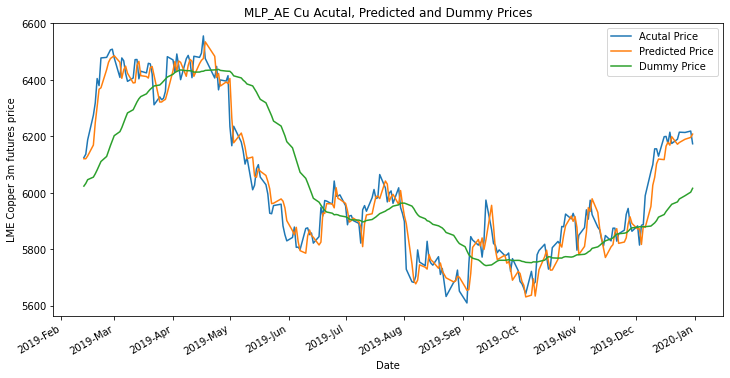

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

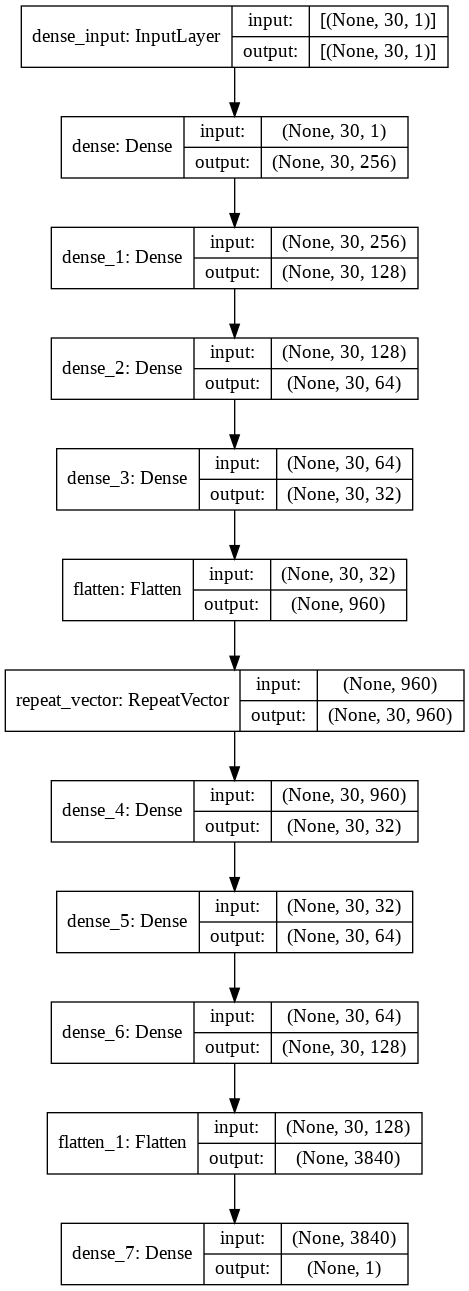

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.0033248508409782565
RMSE:  0.057661519586100544
MAE:  0.045312430299631036
Dummy MSE:  0.02889885289047612
Dummy RMSE:  0.16999662611497945
Dummy MAE:  0.13217330779902475


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/MLP_AE_Cu/assets
